In [1]:
import numpy as np
from scipy.signal import correlate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("outputs/esri_tmin_tmax_pm25_wf_smokePM_fillna_pred_merged.parquet")

In [3]:
df.head()

tmax      tmin      pm25  FIREDAY_NONE_ZEROS  \
time       FIPS                                                        
2005-12-31 1765.0  13.350000  7.850000  4.986000                 NaN   
           1766.0  14.950006  8.249994  5.500000                 NaN   
           1767.0  14.950006  8.249994  5.486667                 NaN   
           1768.0  14.950006  8.249994  5.437778                 NaN   
           1769.0  14.950006  8.249994  5.480000                 NaN   

                   smokePM_pred  
time       FIPS                  
2005-12-31 1765.0           0.0  
           1766.0           0.0  
           1767.0           0.0  
           1768.0           0.0  
           1769.0           0.0

In [4]:
df = df.rename(columns={"FIREDAY_NONE_ZEROS":"wfday"}) # wildfire day - 1.0 if yes, 0.0 if no

In [5]:
df=df.reset_index()

## Select for FIPS with wildfires

In [6]:
df_total_wfday = df.groupby("FIPS")["wfday"].sum().reset_index(name ='total_wfdays')

In [7]:
df_total_wfday = df_total_wfday[df_total_wfday['total_wfdays'] > 0]

In [8]:
wfday_fips = list(df_total_wfday.FIPS)

In [9]:
len(df)

52543404

In [10]:
df = df.dropna()

In [11]:
df = df[df['FIPS'].isin(wfday_fips)]

In [12]:
len(df)

7241286

In [13]:
df.head()

,time,FIPS,tmax,tmin,pm25,wfday,smokePM_pred
8994,2006-01-01,1768.0,13.350000,8.749994,6.845,0.0,0.0
8995,2006-01-01,1769.0,13.350000,8.749994,7.100,0.0,0.0
8997,2006-01-01,1771.0,13.350000,8.749994,6.730,0.0,0.0
8998,2006-01-01,1772.0,13.350000,8.749994,6.030,0.0,0.0
9003,2006-01-01,1777.0,13.950006,9.050013,6.200,0.0,0.0


## Select one location

In [14]:
var1 = df[df.FIPS == 3860.0]['tmax']
var2 = df[df.FIPS == 3860.0]['smokePM_pred']

## First implementation

In [15]:
# Pre-allocate correlation array
corr = (len(var1) - len(var2) + 1) * [0]
var1 = list(var1)
var2 = list(var2)
# Go through lag components one-by-one
for l in range(len(corr)):
    corr[l] = sum([var1[i+l] * var2[i] for i in range(len(var2))])

In [16]:
corr

[49498.36006433093]

## NumPy

In [17]:
corr = np.correlate(var1, var2, mode="same")

In [18]:
np.mean(var2)

0.3051708720254715

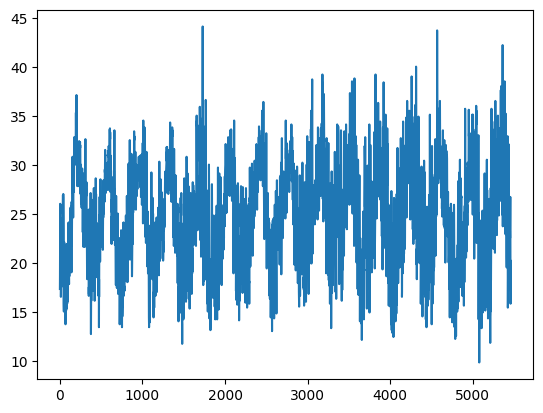

In [19]:
plt.plot(var1)

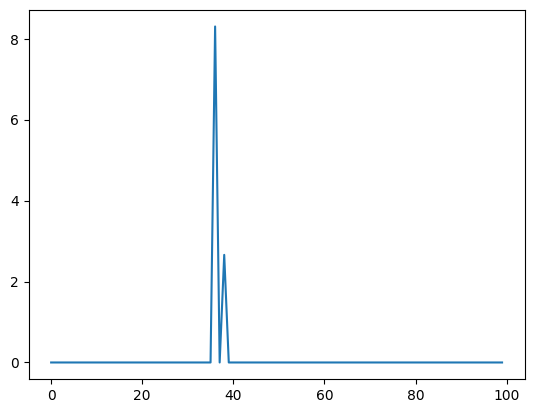

In [20]:
plt.plot(var2[:100])

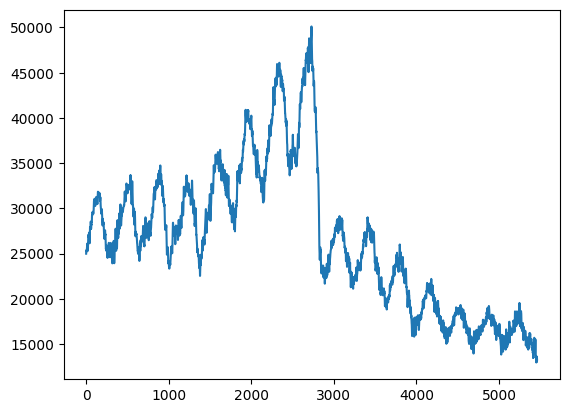

In [21]:
plt.plot(corr)

In [22]:
import scipy.signal  

corr = scipy.signal.correlate(var1, var2)

# Remove padded correlations
corr = corr[(len(var1)-len(var2)-1):len(corr)-((len(var1)-len(var2)-1))]

print(corr)

[-2.72540671e-12]


Best Time Lag: -1


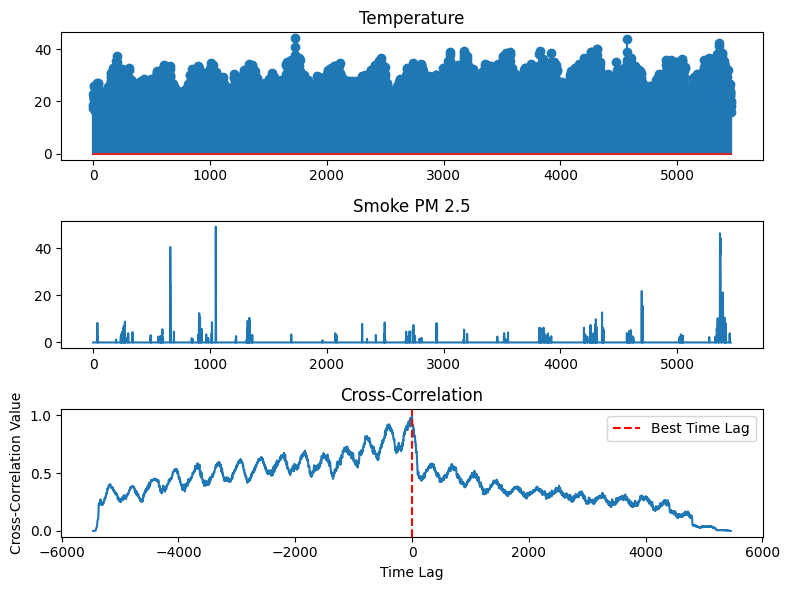

In [30]:
# Calculate cross-correlation
cross_corr = correlate(var1, var2, mode='full')
cross_corr /= np.max(cross_corr)

# Determine time lags for visualization
time_lags = np.arange(-len(var1) + 1, len(var2))

# Find time lag with maximum cross-correlation
best_time_lag = time_lags[np.argmax(cross_corr)]

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].stem(var1)
ax[0].set_title('Temperature')

# Plot continuous signal
ax[1].plot(var2)
ax[1].set_title('Smoke PM 2.5')

# Plot cross-correlation
ax[2].plot(time_lags, cross_corr)
ax[2].set_title('Cross-Correlation')
ax[2].set_xlabel('Time Lag')
ax[2].set_ylabel('Cross-Correlation Value')

# Mark best time lag on the plot
ax[2].axvline(best_time_lag, color='r', linestyle='--', label='Best Time Lag')
ax[2].legend()

plt.tight_layout()


plt.savefig("figures/cross-correlation.png")

print('Best Time Lag:', best_time_lag)
plt.show()